<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Análise de Risco de Crédito direcionada por Modelagem Matemática e Estatística
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este Notebook concentra código fonte da Tese de Bacharelado do curso de Engenharia de Controle e Automação da UNESP Sorocaba desenvolvido pelo aluno Leonardo Aderaldo Vargas.  </i> 
</p>  

# <font color='red' style='font-size: 40px;'> Problemática </font>
<hr style='border: 2px solid red;'>

Amostra baseada na base de dados do Lending Club Loan Data : https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv/data

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Lending Club é uma empresa de empréstimos peer-to-peer com sede nos EUA. Eles combinam pessoas que desejam investir dinheiro com pessoas que desejam pedir dinheiro emprestado. Quando os investidores investem o seu dinheiro através do Lending Club, esse dinheiro é repassado aos mutuários e, quando os mutuários pagam os seus empréstimos, o capital mais os juros são repassados ​​aos investidores. É uma vitória para todos, pois podem obter taxas de empréstimo normalmente mais baixas e retornos mais elevados para os investidores.</i>
</p>  

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i>O conjunto de dados Lending Club contém dados completos de empréstimos para todos os empréstimos emitidos entre 2007-2015, incluindo a situação atual do empréstimo (atual, atrasado, totalmente pago, etc.) e as informações de pagamento mais recentes. Os recursos (também conhecidos como variáveis) incluem pontuação de crédito, número de consultas financeiras, endereço incluindo códigos postais e estado, e cobranças, entre outros. As cobranças indicam se o cliente perdeu um ou mais pagamentos e a equipe está tentando recuperar o dinheiro. O arquivo é uma amostra da base de dados exposta.</i>
</p>  





# <font color='red' style='font-size: 40px;'> Library   </font>
<hr style='border: 2px solid red;'>

In [4]:
# Importação das Bibliotecas e Parâmetros de Otimização
from functions import *
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# Spark Session
from pyspark.sql import SparkSession, Row 
#from pyspark.sql.functions import * as F
import pyspark.sql.functions as F
spark = SparkSession.builder.getOrCreate()

# <font color='red' style='font-size: 40px;'> 1. Entendimento da Base de Dados </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 1.1) Descrição da Base de Dados </font>
<hr style='border: 2px solid green;'>

### Variável Target

 > 1. loan_status: Situação atual do empréstimo, sendo possível classificar o Cliente em Bom ou Ruim

### Variáveis Referentes ao Produto

 > 1. term: O número de pagamentos do empréstimo, podendo serem 36 parcelas ou 60 (IMPORTANTE)

 > 2. grade: Grau de empréstimo atribuído (IMPORTANTE)

 > 3. sub_grade: Subclasse de empréstimo atribuído (IMPORTANTE)

 > 4. desc: Descrição do motivo do cliente para pegar o empréstimo

 > 5. purpose: Categoria (MCC/CNAE por exemplo) fornecida pelo cliente para pegar o empréstimo (IMPORTANTE)

 > 6. title: Título do empréstimo fornecida pelo cliente

 > 7. addr_state: Status de listagem inicial do empréstimo (IMPORTANTE)

 > 8. application_type: Indica se o empréstimo é um pedido individual ou um pedido conjunto de dois clientes (IMPORTANTE)

 > 9. loan_amnt: Valor do empréstimo solicitado pelo mutuário; Se em algum momento o departamento de crédito reduzir do empréstimo, isso será refletido nesse valor (IMPORTANTE)

 > 10. funded_amnt: Valor total comprometido com esse empréstimo naquele momento (IMPORTANTE)

 > 11. funded_amnt: Montate total comprometido pelos investidores para esse empréstimo naquele momento (IMPORTANTE)

 > 12. int_rate: Taxa de juros do empréstimo (IMPORTANTE)

 > 13. issue_d: Data em que o empréstimo foi financiado (IMPORTANTE)

 > 14. policy_code: Flag que indica Produto disponível publicamente ou não (IMPORTANTE)

 > 15. last_credit_pull_d: Mês mais recente que a LC retirou crédito para este empréstimo (IMPORTANTE)

 > 16. mths_since_last_delinq: Número de meses desde a última inadimplência do usuário (IMPORTANTE)


 ### Variáveis Referentes ao Cliente

 > 1. emp_title: O cargo fornecido pelo cliente ao solicitar o empréstimo (IMPORTANTE)

 > 2. emp_length: Duração do emprego que ele está em anos, sendo que 0 significa menos de 1 ano e 10 significa dez ou mais anos (IMPORTANTE)

 > 3. home_ownership: Flag que indica o Status da propriedade residencial do cliente ao solicitar o empréstimo, podenso ser aluguel, próprio, hipoteca, outros. (IMPORTANTE)

 > 4. verification_status: Flag que indica se a renda foi comprovada, não comprovada (IMPORTANTE)

 > 5. annual_inc: Renda anual declarada pelo cliente (IMPORTANTE)

 > 6. tot_cur_bal: Limite total considerando todos os produtos de crédito (IMPORTANTE)

 > 7. total_rev_hi_lim: Limite de rotativos total (IMPORTANTE)
 
 > 6. revol_bal: Limite de rotativos utilizado (IMPORTANTE)

 > 7. revol_util: Taxa de utilização de Limite de rotativos (IMPORTANTE)

 > 8. total_bal_il: Saldo atual total de todas as contas parceladas (IMPORTANTE)

 > 9. il_util: Proporção entre o saldo atual total e o limite de crédito/crédito alto em todas as contas de instalação (IMPORTANTE)

 > 10. open_rv_12m: Número de negociações rotativas abertas nos últimos 12 meses (IMPORTANTE)

 > 11. open_rv_24m: Número de negociações rotativas abertas nos últimos 24 meses (IMPORTANTE)

 > 12. open_acc: Número de produtos de crédito atualmente contratados no histórico do cliente (IMPORTANTE)

 > 13. open_acc_6m: Número de produtos de crédito atualmente contratados no histórico do cliente  (IMPORTANTE)

 > 14. total_acc: Número total de produtos de crédito contratados no histórico do cliente (IMPORTANTE)

 > 15. max_bal_bc: Saldo atual máximo devido em todas as contas (IMPORTANTE)

 > 16. all_util: Saldo até o limite de crédito em todas as negociações (IMPORTANTE)

 > 17. acc_now_delinq: Número de contas nas quais o mutuário está atualmente inadimplente (IMPORTANTE)

 > 18. open_il_6m: Número de contas parceladas abertas nos últimos 6 meses (IMPORTANTE)

 > 19. open_il_12m: Número de contas parceladas abertas nos últimos 12 meses (IMPORTANTE)

 > 20. open_il_24m: Número de contas parceladas abertas nos últimos 24 meses (IMPORTANTE)

 > 21. out_prncp: Capital restante em aberto para parte do valor total financiado pelos investidores

 > 22. out_prncp_inv: Capital restante em aberto para parte do valor total financiado pelos investidores

 > 23. inq_last_12m: Número de consultas de crédito nos últimos 12 meses (IMPORTANTE)

 > 24. zip_code: 3 primeiros números do CEP do cliente (IMPORTANTE)

 > 25. addr_state: Estado do Cliente (IMPORTANTE)

 > 26. earliest_cr_line: Data em que o primeiro produto de crédito foi contratado pelo cliente (IMPORTANTE)

 > 27. mths_since_last_record: Número de meses desde o último registro público (IMPORTANTE)

 > 28. mths_since_last_major_derog: Meses desde a classificação mais recente de 90 dias ou menos (IMPORTANTE)

 > 29. mths_since_rcnt_il: Meses desde a abertura das contas parceladas mais recentes (IMPORTANTE)

 ### Variáveis de Pagamento

 > 1. pymnt_plan: Flag que indica se um plano de pagamento foi implementado para o empréstimo (IMPORTANTE)

 > 2. last_pymnt_d: Data do último pagamento (IMPORTANTE)

 > 3. next_pymnt_d: Data do próximo pagamento (IMPORTANTE)

 > 4. total_pymnt: Pagamentos recebidos até o momento pelo valor total financiado (IMPORTANTE)

 > 5. total_pymnt_inv: Pagamentos recebidos até o momento referentes a parte do valor total financiado pelos investidores 

 > 6. last_pymnt_amnt: Último valor do pagamento

 > 7. total_rec_prncp: Capital (valor originalmente emprestado) pago até o momento (IMPORTANTE)

 > 8. total_rec_int: Juros pago até o momento (IMPORTANTE)

 > 9. total_rec_late_fee: Taxas atrasadas até o momento (IMPORTANTE)

 > 10. recoveries: Pós cobrança da recuperação bruta (IMPORTANTE)

 > 11. collection_recovery_fee: Pós cobrança da taxa de cobrança (IMPORTANTE)

 > 12. tot_coll_amt: Valores totais de cobrança já devidos (IMPORTANTE)

 > 13. installment: Parcela mensal que o mutuário paga se o empréstimo for originado. Em termos simples, a originação de um empréstimo é o ponto de partida, onde o mutuário (a pessoa ou entidade que pede o empréstimo) solicita o empréstimo a um credor (a instituição financeira ou pessoa que empresta o dinheiro) e o credor avalia a solicitação, verifica a elegibilidade do mutuário e decide se concederá ou não o empréstimo. (IMPORTANTE)

 > 14. dti: Uma razão calculada utilizando o total dos pagamentos mensais da dívida do mutuário sobre o total das obrigações da dívida, excluindo a hipoteca e o empréstimo em ML solicitado, dividido pelo rendimento mensal autodeclarado pelo mutuário. (IMPORTANTE)


In [8]:
df = pd.read_parquet('data/credit_risk_loan_data.parquet').drop(['id', 'url'], axis = 1)

# <font color='green' style='font-size: 30px;'> 1.2) Definição da Target </font>
<hr style='border: 2px solid green;'>

> 1. A priori, deve-se definir de maneira clara as situações consideradas como Default 

> 2. A partir desta definição, deve-se criar a Target mostrando exatamente o que é um cliente Bom ou Ruim 

> 3. Escolheu-se o número "0" para representar o cliente Bom e o número "1" para representar o cliente Ruim, pois o evento de interesse é definir principalmente quem são os Maus Pagadores a fim de evitar ao máximo a inadimplêmcia

> 4. Nota-se que em torno de 89% dos clientes são adimplentes, ao passo que 11% tornou-se inadimplente

> 5. Esta situação caracteriza um problema de classes desbalanceadas, portanto, isso deve-se ser levado em consideração durante o processo de modelagem e aplicar técnicas para lidar com este tipo de caso

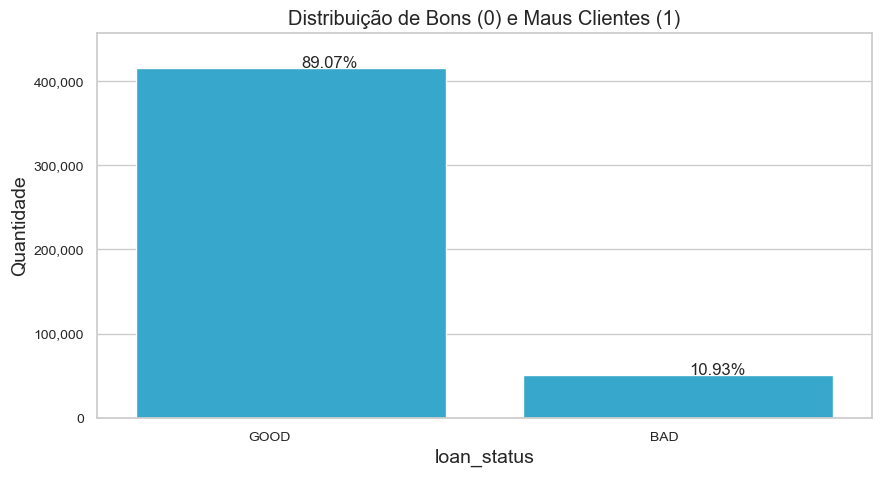

In [9]:
df['loan_status'] = np.where(df['loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']), 'BAD', 'GOOD') 
plota_barras(['loan_status'], False, df, 1, 1, 'Distribuição de Bons (0) e Maus Clientes (1)', 0)

# <font color='green' style='font-size: 30px;'> 1.3) Separação em Treino e Teste </font>
<hr style='border: 2px solid green;'>

> 1. Antes de realizar qualquer análise ou modelagem, deve-se separar em Treino e Teste a fim de simular um ambiente real

> 2. Ao separar antes de qualquer alteração, evita-se um erro muito grave denominado Data leakage

> 3. As análises serão realizadas unicamente sobre a base de Treinamento, simulando um ambiente real no qual a priori a base de Teste seria inexistente 

In [10]:
df_train = separa_treino_teste('loan_status', df, 0.20)[0]
df_test = separa_treino_teste('loan_status', df, 0.20)[1]

print(f'Quantidade de Dados Utilizados para Treinamento: {df_train.shape[0]}')
print(f'Quantidade de Dados Utilizados para Teste: {df_test.shape[0]}')

Quantidade de Dados Utilizados para Treinamento: 373028
Quantidade de Dados Utilizados para Teste: 93257


# <font color='green' style='font-size: 30px;'> 1.4) Verificação de Variáveis Contínuas, Discretas e Categóricas </font>
<hr style='border: 2px solid green;'>

> 1. Para facilitar a Análise Exploratória, segmentou-se as variáveis em Qualitativas, Discretas e Contínuas.

> 2. Definiu-se essas classificações a fim de aplicar técnicas estatatísticas corretas para analisá-las

> 3. Essa abordagem é importante pois cada tipo de variável tem determinado jeito de ser analisada. 

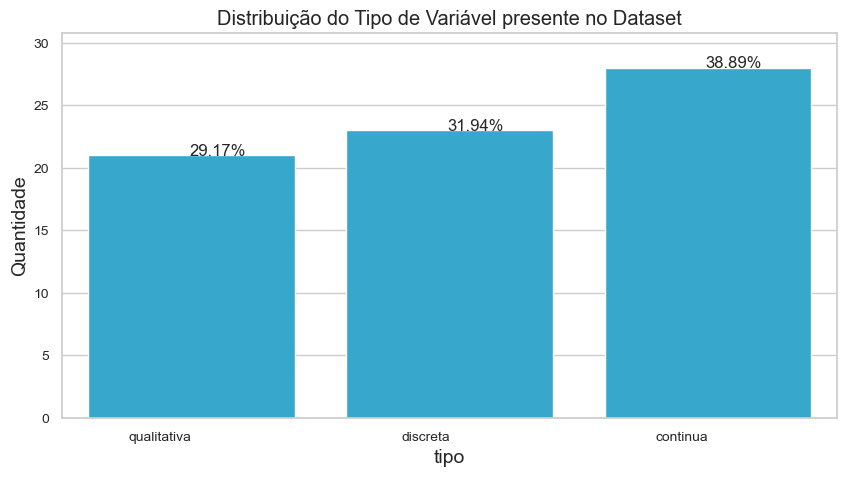

In [12]:
variaveis = verifica_tipo_variavel(df)
plota_barras(['tipo'], False, variaveis, 1, 1, 'Distribuição do Tipo de Variável presente no Dataset', 0)

# <font color='red' style='font-size: 40px;'> 2. Análise De Variáveis Referentes ao Produto </font>
<hr style='border: 2px solid red;'>

### Variáveis Referentes ao Produto

 > 1. term: O número de pagamentos do empréstimo, podendo serem 36 parcelas ou 60 (IMPORTANTE) ($ FEITO $ )

 > 2. grade: Grau de empréstimo atribuído (IMPORTANTE)

 > 3. sub_grade: Subclasse de empréstimo atribuído (IMPORTANTE)

 > 4. desc: Descrição do motivo do cliente para pegar o empréstimo

 > 5. purpose: Categoria (MCC/CNAE por exemplo) fornecida pelo cliente para pegar o empréstimo (IMPORTANTE)

 > 6. title: Título do empréstimo fornecida pelo cliente

 > 7. addr_state: Status de listagem inicial do empréstimo (IMPORTANTE)

 > 8. application_type: Indica se o empréstimo é um pedido individual ou um pedido conjunto de dois clientes (IMPORTANTE)

 > 9. loan_amnt: Valor do empréstimo solicitado pelo mutuário; Se em algum momento o departamento de crédito reduzir do empréstimo, isso será refletido nesse valor (IMPORTANTE)

 > 10. funded_amnt: Valor total comprometido com esse empréstimo naquele momento (IMPORTANTE)

 > 11. funded_amnt: Montate total comprometido pelos investidores para esse empréstimo naquele momento (IMPORTANTE)

 > 12. int_rate: Taxa de juros do empréstimo (IMPORTANTE)

 > 13. issue_d: Data em que o empréstimo foi financiado (IMPORTANTE)

 > 14. policy_code: Flag que indica Produto disponível publicamente ou não (IMPORTANTE)

 > 15. last_credit_pull_d: Mês mais recente que a LC retirou crédito para este empréstimo (IMPORTANTE)

 > 16. mths_since_last_delinq: Número de meses desde a última inadimplência do usuário (IMPORTANTE)

# <font color='green' style='font-size: 30px;'> 2.1) Número de Parcelas vs Target </font>
<hr style='border: 2px solid green;'>

> 1. Em relação ao número de parcelas, nota-se que graficamente elas aparentam ter relação com a PD

> 2. Para provar estatísticamente que há relação significativa, aplicou-se um Teste Chi-Quadrado com as seguintes hipóteses:

- H0: Não há associação entre as variáveis
- H1: Há associação entre as variáveis

> 3. Como o p-value < 0.05, não há evidências suficientes para aceitar H0, portanto, rejeita-se H0 e conclui-se que há associação significativa entre o número de parcelas escolhida pelo cliente e a PD

> 4. Para fins explicativos, aplicou-se também um calculo de Weight of Evidence. WOE é uma métrica usada em análises de crédito para avaliar a força da relação entre uma variável categórica (como o termo do empréstimo) e o risco de inadimplência. Valores positivos de WOE indicam que a categoria está associada a um maior risco de inadimplência, enquanto valores negativos indicam menor risco. No caso apresentado, "36 months" tem um valor de -0.13, o que significa que essa categoria está ligeiramente associada a um menor risco em comparação com "60 months", que tem um valor de 0.30, indicando um risco um pouco maior.

Pelo Teste Qui-Quadrado, há associação significativa entre term e loan_status.


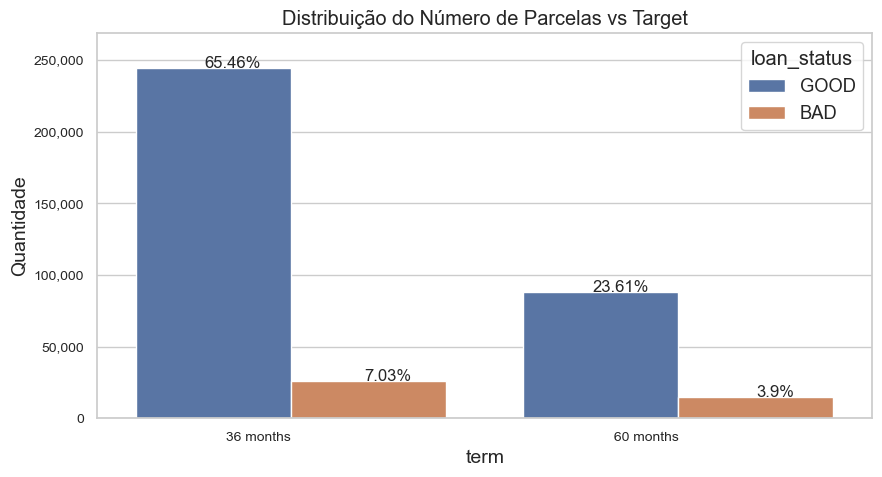

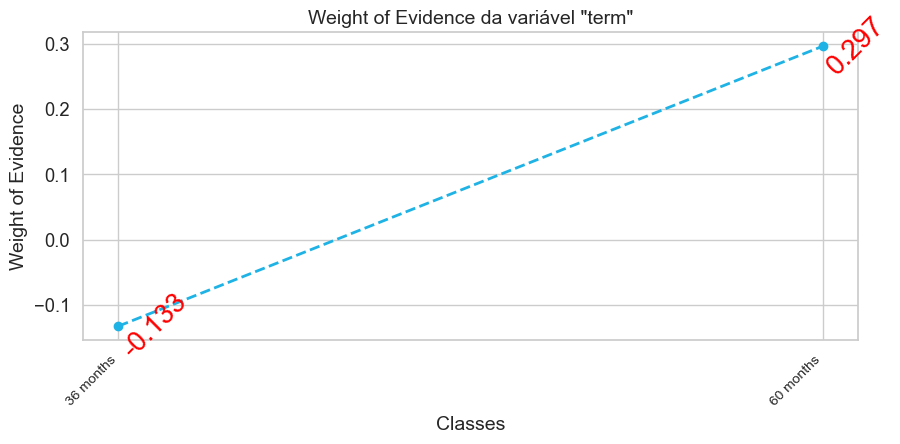

In [13]:
teste_hipotese_duas_variaveis_categoricas(df_train, 'term', 'loan_status')
plota_barras(['term'], 'loan_status', df_train, 1, 1, 'Distribuição do Número de Parcelas vs Target', 0)
woe(df_train, 'term', 'loan_status')

# <font color='green' style='font-size: 30px;'> 2.2) Graus de Empréstimo vs Target </font>
<hr style='border: 2px solid green;'>

> 1. Existem diversos tipo de empréstimo, portanto, a depender do produto contratado a PD pode mudar

> 2. Embora estejam expressas em siglas tornando-se impossível interpretá-las, nota-se que tanto o grau quanto a subclasse possuem associação com a target e alguns graus e subclasses relacionam-se de forma a aumentar ou diminuir a PD.

Pelo Teste Qui-Quadrado, há associação significativa entre grade e loan_status.


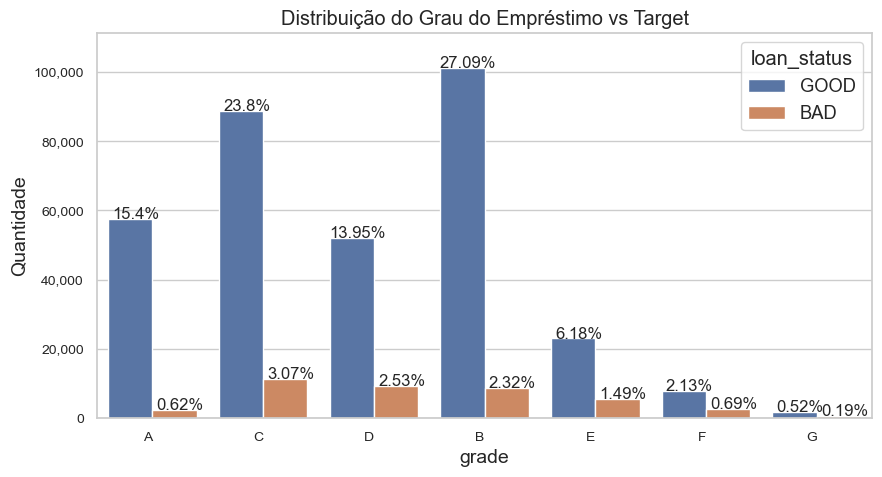

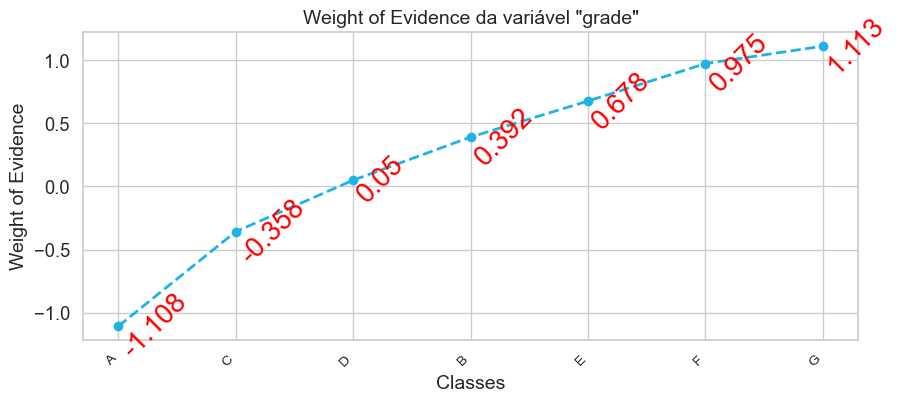

In [14]:
teste_hipotese_duas_variaveis_categoricas(df_train, 'grade', 'loan_status')
plota_barras(['grade'], 'loan_status', df_train, 1, 1, 'Distribuição do Grau do Empréstimo vs Target', 0)
woe(df_train, 'grade', 'loan_status')

Pelo Teste Qui-Quadrado, há associação significativa entre sub_grade e loan_status.


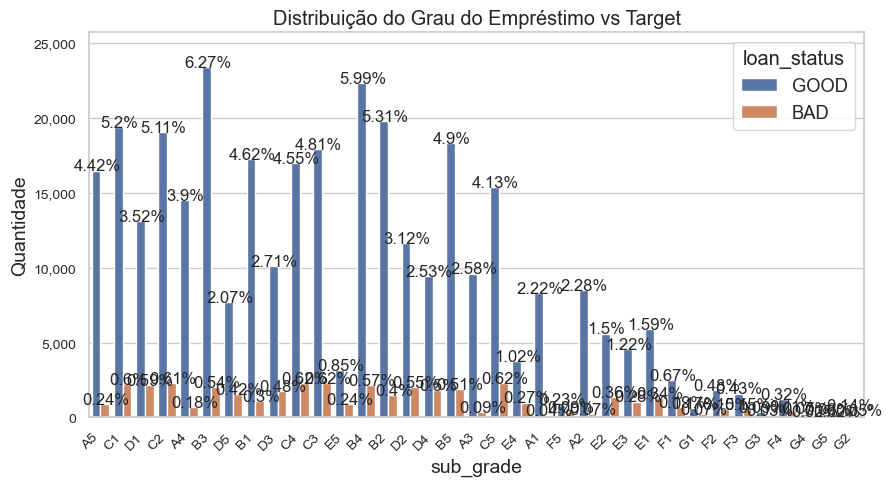

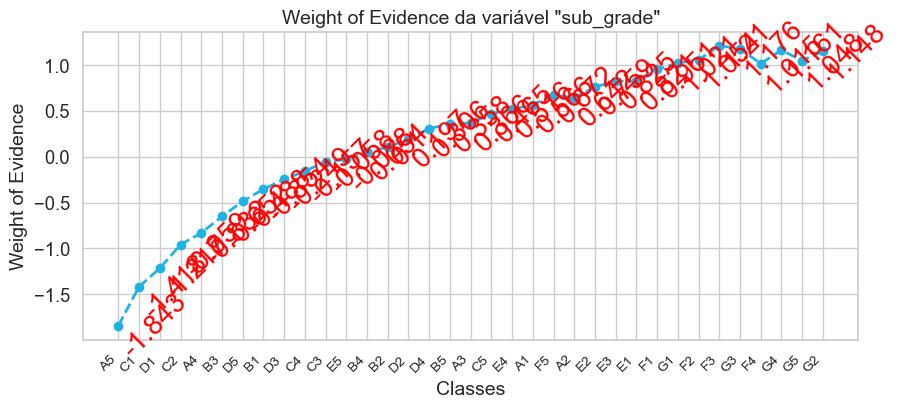

In [15]:
teste_hipotese_duas_variaveis_categoricas(df_train, 'sub_grade', 'loan_status')
plota_barras(['sub_grade'], 'loan_status', df_train, 1, 1, 'Distribuição do Grau do Empréstimo vs Target', 45)
woe(df_train, 'sub_grade', 'loan_status')

# <font color='green' style='font-size: 30px;'> 2.3) Distribuição da Descrição vs Target </font>
<hr style='border: 2px solid green;'>

> 1. Pelo Teste do Chi-Quadrado, novamente nota-se associação entre as variáveis

> 2. Variáveis como debt_consolidation, education, credit_card, wedding demonstram ser motivos menos relacionados a inadimplência

> 3. Já as variáveis home_improvement, major_purchase, small_business, vacation, house, car, moving, renewable_energy, medical tendem a oferecer maior risco.

Pelo Teste Qui-Quadrado, há associação significativa entre purpose e loan_status.


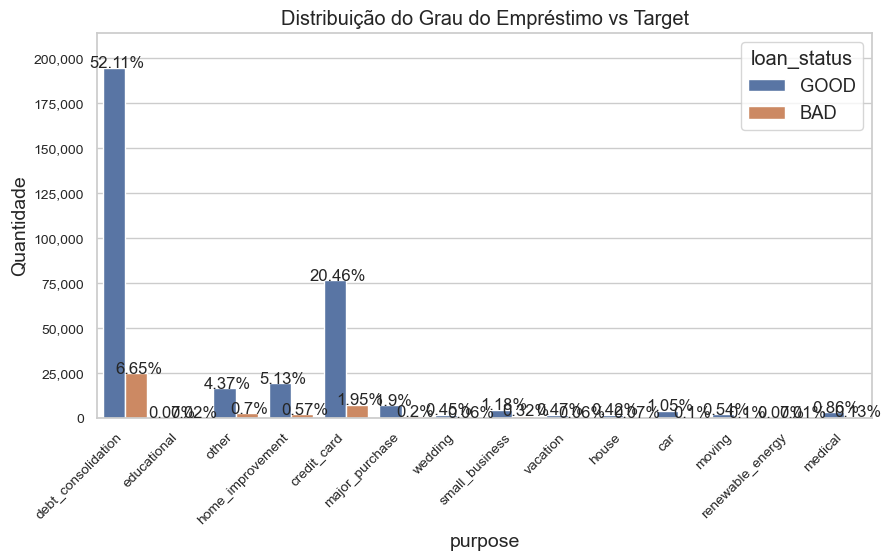

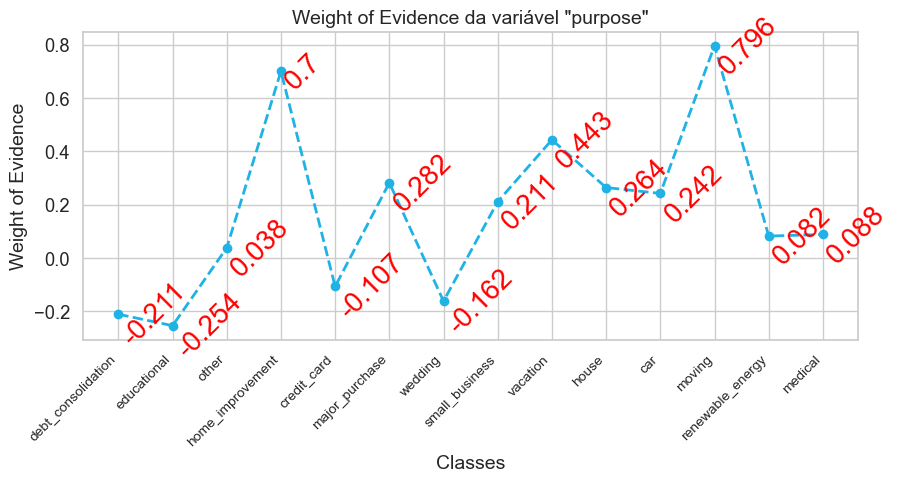

In [17]:
teste_hipotese_duas_variaveis_categoricas(df_train, 'purpose', 'loan_status')
plota_barras(['purpose'], 'loan_status', df_train, 1, 1, 'Distribuição do Grau do Empréstimo vs Target', 45)
woe(df_train, 'purpose', 'loan_status')

# <font color='green' style='font-size: 30px;'> 2.3) Distribuição de Endereços </font>
<hr style='border: 2px solid green;'>

> 1. A distribuição dos Estados segue relativamente equilibrada, com destaque para os estados CA, NY, TX e FL que são consideravelmente mais populadas que os demais estados

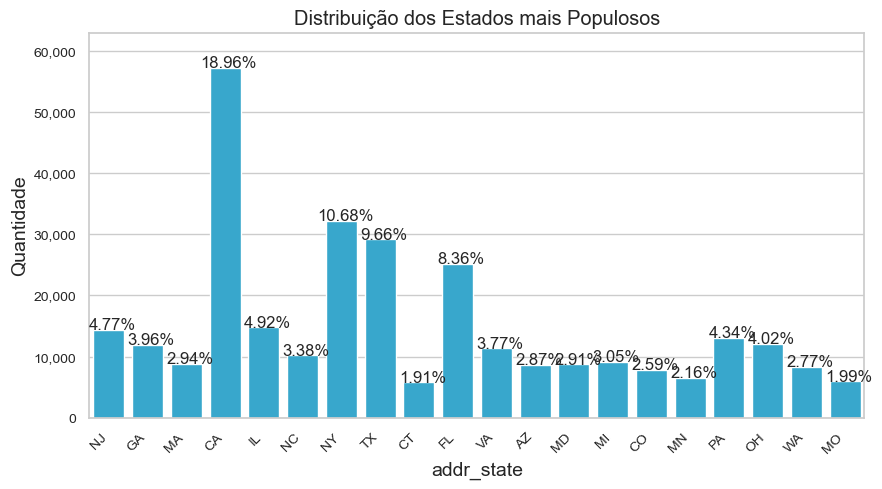

In [ ]:
plota_barras(['addr_state'], False, df_train.loc[df_train['addr_state'].isin(list(df_train.groupby('addr_state', as_index=False)['member_id'].count().sort_values(by = 'member_id', ascending = False).iloc[:20, :]['addr_state'].unique()))], 1, 1, 'Distribuição dos Estados mais Populosos')

# <font color='red' style='font-size: 40px;'> 3. Análise de Variáveis Referentes ao Cliente  </font>
<hr style='border: 2px solid red;'>

 ### Variáveis Referentes ao Cliente

 > 1. emp_title: O cargo fornecido pelo cliente ao solicitar o empréstimo (IMPORTANTE)

 > 2. emp_length: Duração do emprego que ele está em anos, sendo que 0 significa menos de 1 ano e 10 significa dez ou mais anos (IMPORTANTE)

 > 3. home_ownership: Flag que indica o Status da propriedade residencial do cliente ao solicitar o empréstimo, podenso ser aluguel, próprio, hipoteca, outros. (IMPORTANTE)

 > 4. verification_status: Flag que indica se a renda foi comprovada, não comprovada (IMPORTANTE)

 > 5. annual_inc: Renda anual declarada pelo cliente (IMPORTANTE)

 > 6. tot_cur_bal: Limite total considerando todos os produtos de crédito (IMPORTANTE)

 > 7. total_rev_hi_lim: Limite de rotativos total (IMPORTANTE)
 
 > 6. revol_bal: Limite de rotativos utilizado (IMPORTANTE)

 > 7. revol_util: Taxa de utilização de Limite de rotativos (IMPORTANTE)

 > 8. total_bal_il: Saldo atual total de todas as contas parceladas (IMPORTANTE)

 > 9. il_util: Proporção entre o saldo atual total e o limite de crédito/crédito alto em todas as contas de instalação (IMPORTANTE)

 > 10. open_rv_12m: Número de negociações rotativas abertas nos últimos 12 meses (IMPORTANTE)

 > 11. open_rv_24m: Número de negociações rotativas abertas nos últimos 24 meses (IMPORTANTE)

 > 12. open_acc: Número de produtos de crédito atualmente contratados no histórico do cliente (IMPORTANTE)

 > 13. open_acc_6m: Número de produtos de crédito atualmente contratados no histórico do cliente  (IMPORTANTE)

 > 14. total_acc: Número total de produtos de crédito contratados no histórico do cliente (IMPORTANTE)

 > 15. max_bal_bc: Saldo atual máximo devido em todas as contas (IMPORTANTE)

 > 16. all_util: Saldo até o limite de crédito em todas as negociações (IMPORTANTE)

 > 17. acc_now_delinq: Número de contas nas quais o mutuário está atualmente inadimplente (IMPORTANTE)

 > 18. open_il_6m: Número de contas parceladas abertas nos últimos 6 meses (IMPORTANTE)

 > 19. open_il_12m: Número de contas parceladas abertas nos últimos 12 meses (IMPORTANTE)

 > 20. open_il_24m: Número de contas parceladas abertas nos últimos 24 meses (IMPORTANTE)

 > 21. out_prncp: Capital restante em aberto para parte do valor total financiado pelos investidores

 > 22. out_prncp_inv: Capital restante em aberto para parte do valor total financiado pelos investidores

 > 23. inq_last_12m: Número de consultas de crédito nos últimos 12 meses (IMPORTANTE)

 > 24. zip_code: 3 primeiros números do CEP do cliente (IMPORTANTE)

 > 25. addr_state: Estado do Cliente (IMPORTANTE)

 > 26. earliest_cr_line: Data em que o primeiro produto de crédito foi contratado pelo cliente (IMPORTANTE)

 > 27. mths_since_last_record: Número de meses desde o último registro público (IMPORTANTE)

 > 28. mths_since_last_major_derog: Meses desde a classificação mais recente de 90 dias ou menos (IMPORTANTE)

 > 29. mths_since_rcnt_il: Meses desde a abertura das contas parceladas mais recentes (IMPORTANTE)

# <font color='green' style='font-size: 30px;'> 3.1) Descrição da Base de Dados </font>
<hr style='border: 2px solid green;'>

# <font color='red' style='font-size: 40px;'> 4. Análise de Variáveis Referentes ao Pagamento  </font>
<hr style='border: 2px solid red;'>

 ### Variáveis de Pagamento

 > 1. pymnt_plan: Flag que indica se um plano de pagamento foi implementado para o empréstimo (IMPORTANTE)

 > 2. last_pymnt_d: Data do último pagamento (IMPORTANTE)

 > 3. next_pymnt_d: Data do próximo pagamento (IMPORTANTE)

 > 4. total_pymnt: Pagamentos recebidos até o momento pelo valor total financiado (IMPORTANTE)

 > 5. total_pymnt_inv: Pagamentos recebidos até o momento referentes a parte do valor total financiado pelos investidores 

 > 6. last_pymnt_amnt: Último valor do pagamento

 > 7. total_rec_prncp: Capital (valor originalmente emprestado) pago até o momento (IMPORTANTE)

 > 8. total_rec_int: Juros pago até o momento (IMPORTANTE)

 > 9. total_rec_late_fee: Taxas atrasadas até o momento (IMPORTANTE)

 > 10. recoveries: Pós cobrança da recuperação bruta (IMPORTANTE)

 > 11. collection_recovery_fee: Pós cobrança da taxa de cobrança (IMPORTANTE)

 > 12. tot_coll_amt: Valores totais de cobrança já devidos (IMPORTANTE)

 > 13. installment: Parcela mensal que o mutuário paga se o empréstimo for originado. Em termos simples, a originação de um empréstimo é o ponto de partida, onde o mutuário (a pessoa ou entidade que pede o empréstimo) solicita o empréstimo a um credor (a instituição financeira ou pessoa que empresta o dinheiro) e o credor avalia a solicitação, verifica a elegibilidade do mutuário e decide se concederá ou não o empréstimo. (IMPORTANTE)

 > 14. dti: Uma razão calculada utilizando o total dos pagamentos mensais da dívida do mutuário sobre o total das obrigações da dívida, excluindo a hipoteca e o empréstimo em ML solicitado, dividido pelo rendimento mensal autodeclarado pelo mutuário. (IMPORTANTE)


# <font color='green' style='font-size: 30px;'> 4.1) Descrição da Base de Dados </font>
<hr style='border: 2px solid green;'>